<a href="https://colab.research.google.com/github/dominiksakic/zero_to_hero/blob/main/backpropagation_explained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple start


In [284]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Function to explain Backpropagation
def f(x):
  """
  6x^2 - 10
  """
  return 2*x**3 - 10*x + 3

f(3.0)

27.0

- What is the derivate of this function at any given point?

  - What is the derivate telling me about the function?
  - Derivate: if I have a value a and increase it by h, how much does the function change?
  - This change is the slope of the function. And if it is positive it goes up, if it is positive it goes down!

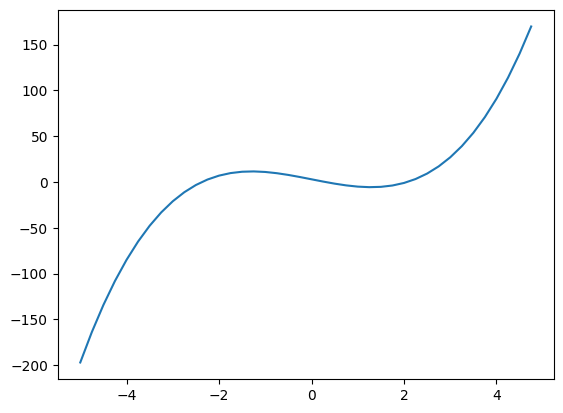

In [285]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

- For the above function, looking at any value in bigger than 2 for x, I would expect the Derivate to be positive!
- Lets test it!

In [286]:
def derivate (x, h):
  """
  Dividing by h gives you the rate of change.
  f(x + h) - f(x) --> Difference between to points.
  /h --> Rate of change, which is the comparision between two things that
  change at the same time.

  The change of rate established a connection.
  """
  return (f(x + h) - f(x))/h

# Numerical approximation of the slope, h has to be close to 0 for better resutls
print(derivate(2, 0.001))
print(derivate(0, 0.001))
print(derivate(-4, 0.001))

14.012001999997636
-9.999998000000065
85.97600199999533


# Add complexity
- What are the derivate in terms of a, b, and c?

In [287]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [288]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
a += h
d2 = a * b + c
derivate = (d2 - d1)/h
# Increasing a decreses d, because you multiply b by a.
# b is negative here -> decrease.
print('d1, ', d1)
print('d2, ', d2)
print('Slope ',  derivate)

d1,  4.0
d2,  3.999699999999999
Slope  -3.000000000010772


In [289]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [290]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
# same as c = a + b
c = a.__add__(b)
c.label = 'c'

In [291]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

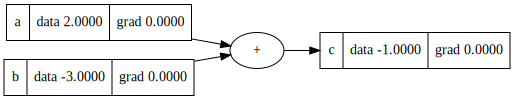

In [292]:
draw_dot(c)


- Next up!
Calculate the Gradient, or spelled out:
The Derivate of each node in terms of final output!

- Zoom out:
1. We have data that is fixed and not fixed.
2. We use a loss function of what we are aiming for, it can be simple like a mean squared error, or more complex.
3. We then adjust the non fixed data, by caluclating the gradient in terms of loss.

In [293]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

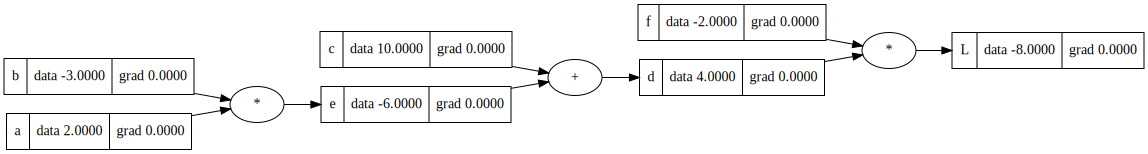

In [294]:
draw_dot(L)

"if we wiggle c, how does that impact L?"

dL/dc
- Numerator(thing on top) the thing taht changes
- Demoniator(thing on bottom) the thing that I am changing

- local derivate
dd/dc ?
d = c + e

- Deriving it form the basics
1. (f(x+h) - f(x))/h
2. (c + h + e - c - e) / h
3. e + h / h
4. e

- But what about the influnce of c for L?

WANT:
dL/dc = (dL / dd ) * (dd/dc)

KNOW:
dL / dd
dd/ dc

In [295]:
# Backwardpass by hand
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
c.grad = -2.0
e.grad = -2.0
a.grad = -3.0 * e.grad
b.grad = 2.0 * e.grad

In [296]:
# Adjust the leaf nodes
print(f"a before applying Gradient with learning rate: {a.data}")
a.data += 0.001 * a.grad
print(f"a after applying Gradient with learning rate: {a.data}")
b.data += 0.001 * b.grad
c.data += 0.001 * c.grad
f.data += 0.001 * f.grad

# Rerun the forward pass
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
L = d * f; L.label = 'L'
L

# Single step finished.
# Calculate the gradient again and do it over and over again!

a before applying Gradient with learning rate: 2.0
a after applying Gradient with learning rate: 2.006


Value(data=-7.928064095999999)

In [297]:
# Backwardpass by hand
def lol():
  h = 0.0001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0 + h, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1) / h)

lol()


-4.000000000008441


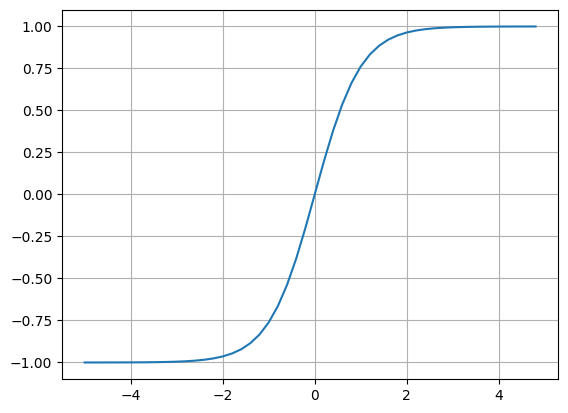

In [298]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [299]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

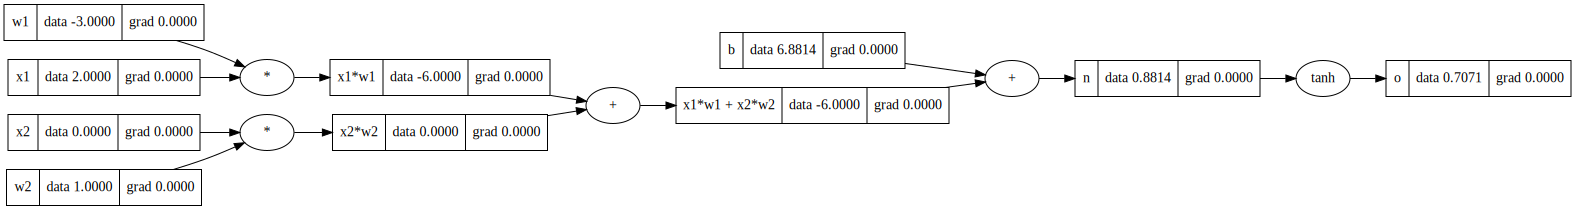

In [300]:
draw_dot(o)

In [301]:
o.grad = 1.0
n.grad = 0.5
b.grad = 0.5
x1w1x2w2.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
w2.grad = x2.data * x2w2.grad
x2.grad = w2.data * x2w2.grad
w1.grad = x1.data * x1w1.grad
x1.grad = w1.data * x1w1.grad

- do/do = 1.0
- do/dn = 1 - tanh(n) ** 2

In [302]:
# Gradient inline check
def lol():
  h = 0.0001

  x1 = Value(2.0, label='x1')
  x2 = Value(0.0, label='x2')
  # weights w1,w2
  w1 = Value(-3.0, label='w1')
  w2 = Value(1.0, label='w2')
  # bias of the neuron
  b = Value(6.8813735870195432, label='b')
  # x1*w1 + x2*w2 + b
  x1w1 = x1*w1; x1w1.label = 'x1*w1'
  x2w2 = x2*w2; x2w2.label = 'x2*w2'
  x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
  n = x1w1x2w2 + b; n.label = 'n'
  o = n.tanh(); o.label = 'o'
  L1 = o.data

  x1 = Value(2.0, label='x1')
  x2 = Value(0.0, label='x2')
  # weights w1,w2
  w1 = Value(-3.0, label='w1')
  w2 = Value(1.0, label='w2')
  # bias of the neuron
  b = Value(6.8813735870195432, label='b')
  # x1*w1 + x2*w2 + b
  x1w1 = x1*w1; x1w1.label = 'x1*w1'
  x2w2 = x2*w2; x2w2.label = 'x2*w2'
  x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
  n = x1w1x2w2 + b; n.label = 'n'
  o = n.tanh(); o.label = 'o'
  L2 = o.data

  print((L2 - L1) / h)

lol()


0.0


In [303]:
# Use newly implemented backward

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

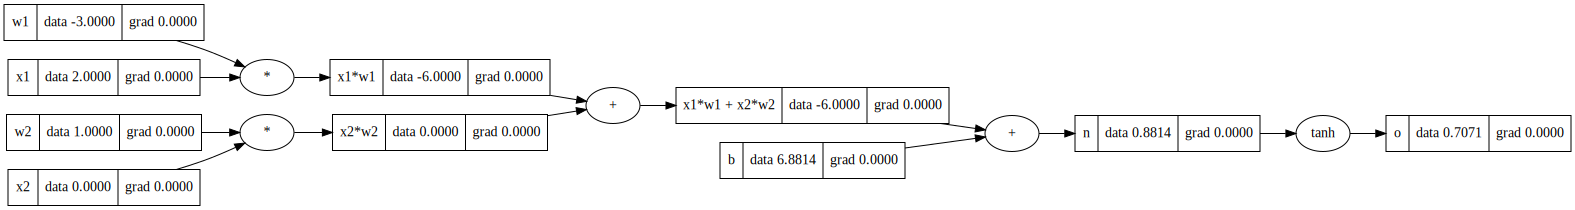

In [304]:
draw_dot(o)

In [305]:
# Base case
o.backward()

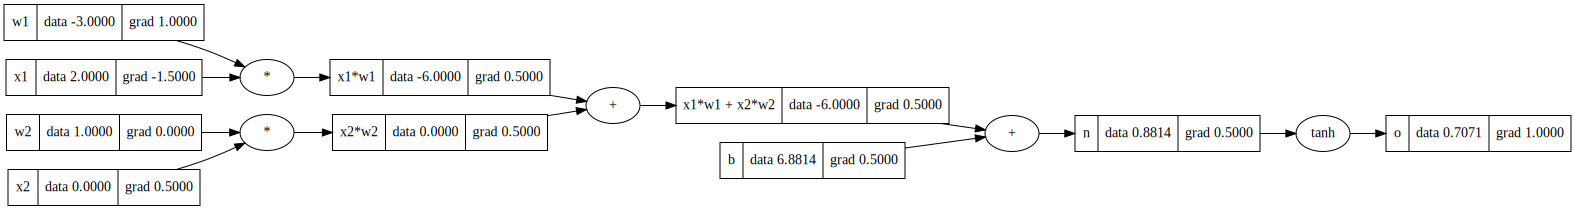

In [306]:
draw_dot(o)

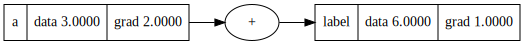

In [307]:
# Edge case:
a = Value(3.0, label='a')
b = a + a; b.label = 'label'
b.backward()
draw_dot(b)

# Gradient should be 2

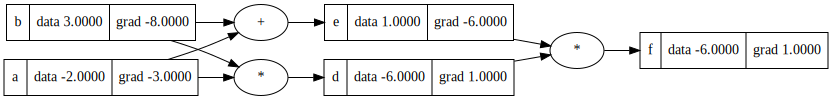

In [308]:
# Issue of Vlaue object, if a Value is used more than once.
# Solution accumulate the gradients.
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

In [309]:
# Pytorch comparision
import torch

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [310]:
import random

class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.936717206982378)

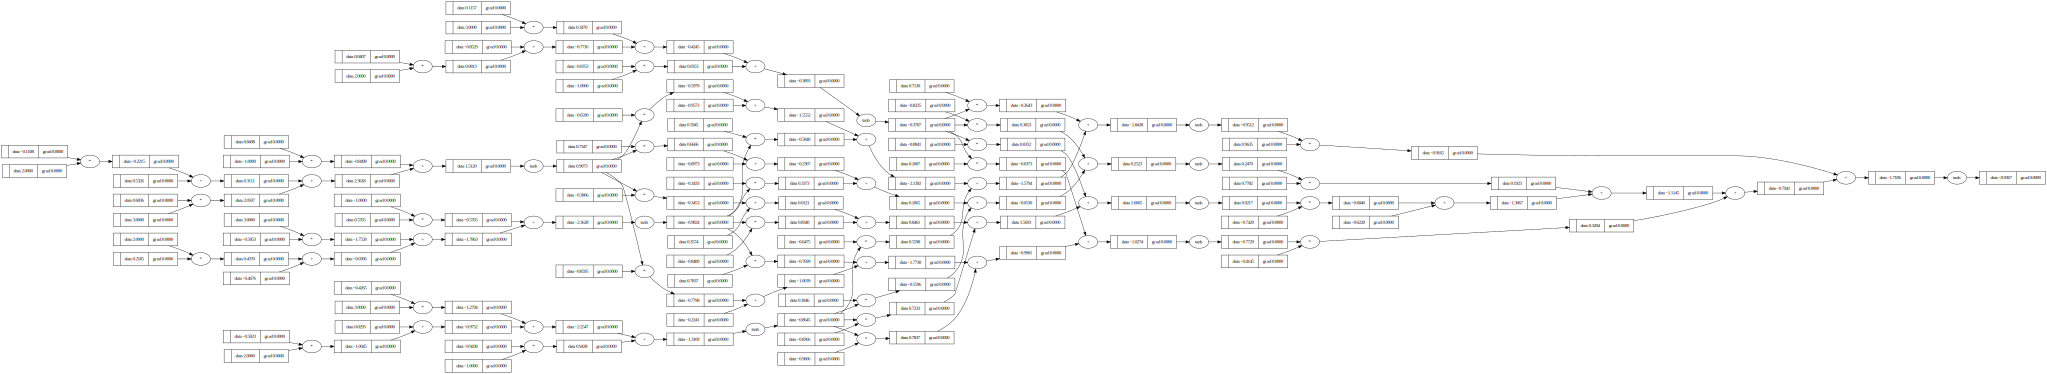

In [311]:
draw_dot(n(x))

In [312]:
# Dataset
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

# Current preds for the random initialized NN
ypred = [n(x) for  x in xs]
ypred

[Value(data=-0.936717206982378),
 Value(data=-0.9747702943073141),
 Value(data=-0.9340513140320337),
 Value(data=-0.9380781221515299)]

In [313]:
for k in range(20):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0 # Zero grad!
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(k, loss.data)

0 7.512006114614264
1 6.388753946793646
2 1.8034010514908954
3 0.9170573926960403
4 0.2678361504867395
5 0.10389423230122374
6 0.06789046896618298
7 0.05234097976217837
8 0.04262438403780466
9 0.035943747749583685
10 0.031064169342370083
11 0.02734339069428767
12 0.024412687464698407
13 0.022044905937876627
14 0.02009237423901783
15 0.018454907249250987
16 0.017062131343223107
17 0.015863162262236934
18 0.014820295840545474
19 0.013905001254590914


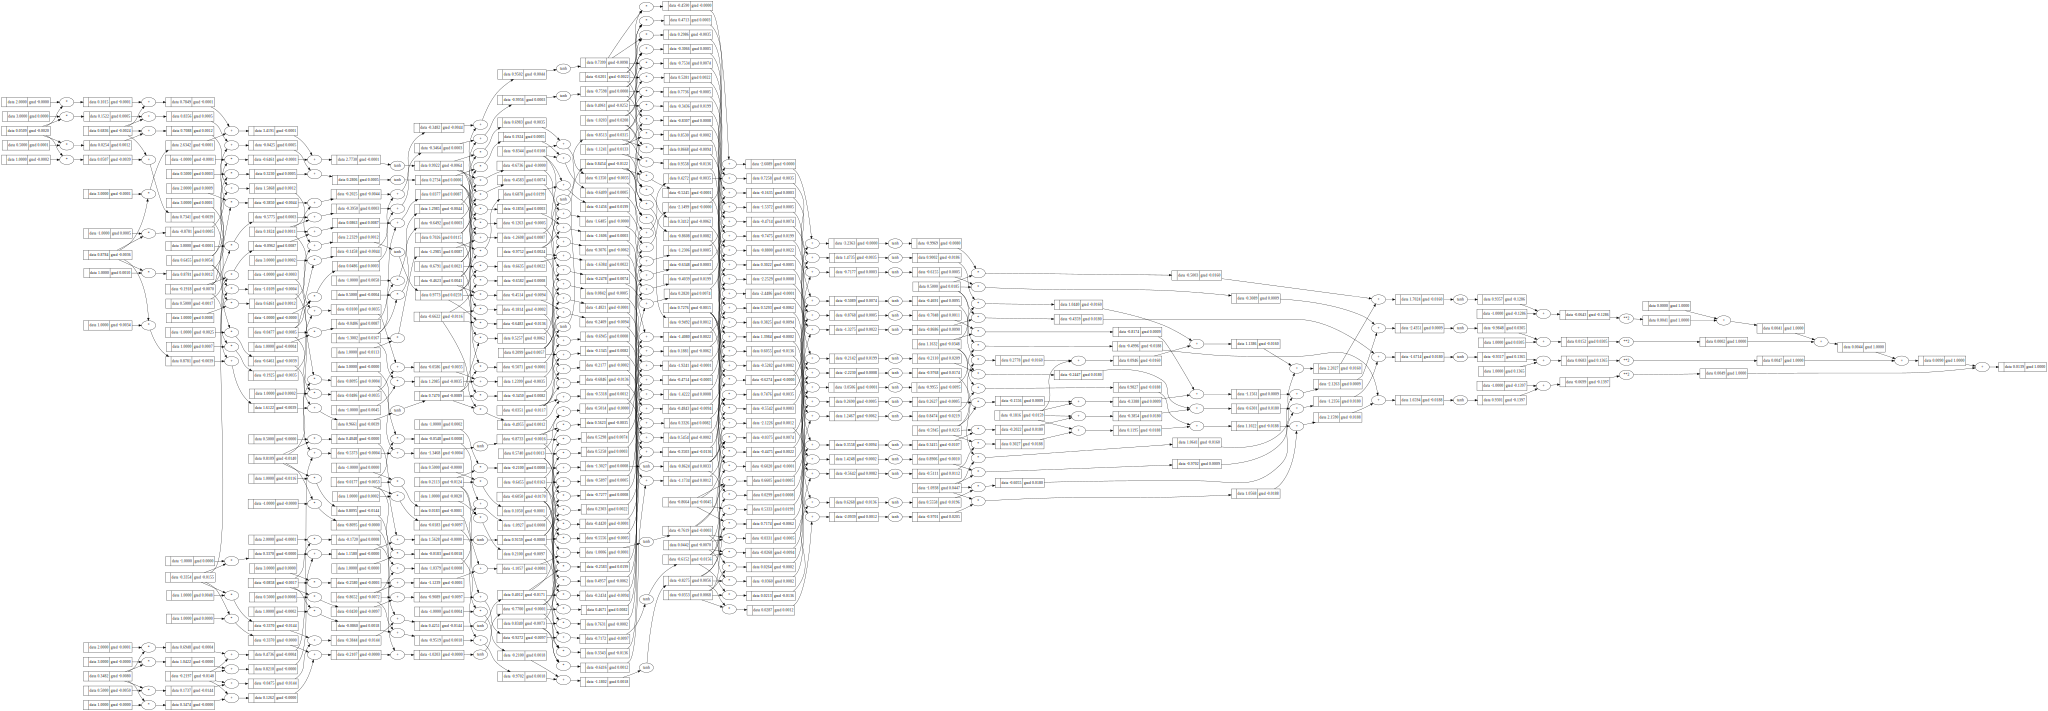

In [314]:
draw_dot(loss)

In [315]:
ypred

[Value(data=0.9357130174304646),
 Value(data=-0.9847746601478321),
 Value(data=-0.9317429207729176),
 Value(data=0.9301333750030176)]

In [316]:
n.parameters()

[Value(data=0.050938502406450835),
 Value(data=0.8784376121520391),
 Value(data=0.6455364598904747),
 Value(data=0.6836358333952263),
 Value(data=0.3481964881511864),
 Value(data=-0.335408397224577),
 Value(data=0.8109467216888339),
 Value(data=-0.2196959404800723),
 Value(data=-0.19179162813941691),
 Value(data=-0.047737901634334654),
 Value(data=-1.3001525234870053),
 Value(data=0.18239458543440304),
 Value(data=-0.08581473699868179),
 Value(data=-0.017733647169389008),
 Value(data=0.21126369665677877),
 Value(data=-0.8652321725902781),
 Value(data=-0.46227938840022775),
 Value(data=-0.6049702757769114),
 Value(data=-1.0203173736757984),
 Value(data=0.044196818878264314),
 Value(data=0.20990998580054193),
 Value(data=0.7026352420062977),
 Value(data=-0.6454566601741741),
 Value(data=0.4061196311464827),
 Value(data=-0.8664334252421779),
 Value(data=-0.8344427025338891),
 Value(data=-0.6621990160576479),
 Value(data=0.8339550919389503),
 Value(data=-1.124057492697388),
 Value(data=-0.